In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone
import vaex

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics
from utils.data import get_events, get_sections, process_df, export_dataframe_to_latex, load_df as load_df_inner
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

In [2]:
def compute_df_soc(df, nominal_Q, inplace=False):
    """
    Compute the State of Charge (SOC) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the SOC values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed SOC values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output SOC values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed SOC values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    SOC = df['batt_Q'].to_numpy() / nominal_Q

    if inplace:
        df['batt_z'] = SOC
    return SOC

def compute_df_capacity(df, nominal_Q, initial_SOC, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_SOC (float): Initial State of Charge (SOC) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_SOC` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df['t'] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q * initial_SOC) - cumtrapz(df['batt_i'], time_hours, initial=0)  # units: Amper-hour

    if inplace:
        df['batt_Q'] = Q
    return Q

def load_df(filename, start, end, resample_rule, rename_columns, print_columns, iqr_threshold, cutoff_freq, sampling_rate, order, nominal_Q, initial_SOC):
    df = load_df_inner(
        filename=filename,
        start=start,
        end=end,
        resample_rule=resample_rule,
        rename_columns=rename_columns,
        print_columns=print_columns,
        iqr_threshold=iqr_threshold,
        cutoff_freq=cutoff_freq,
        sampling_rate=sampling_rate,
        order=order,
    )

    compute_df_capacity(df, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q, inplace=True)

    return df

cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 0.99

Train size ≃ 27.01%
Test size ≃ 72.99%


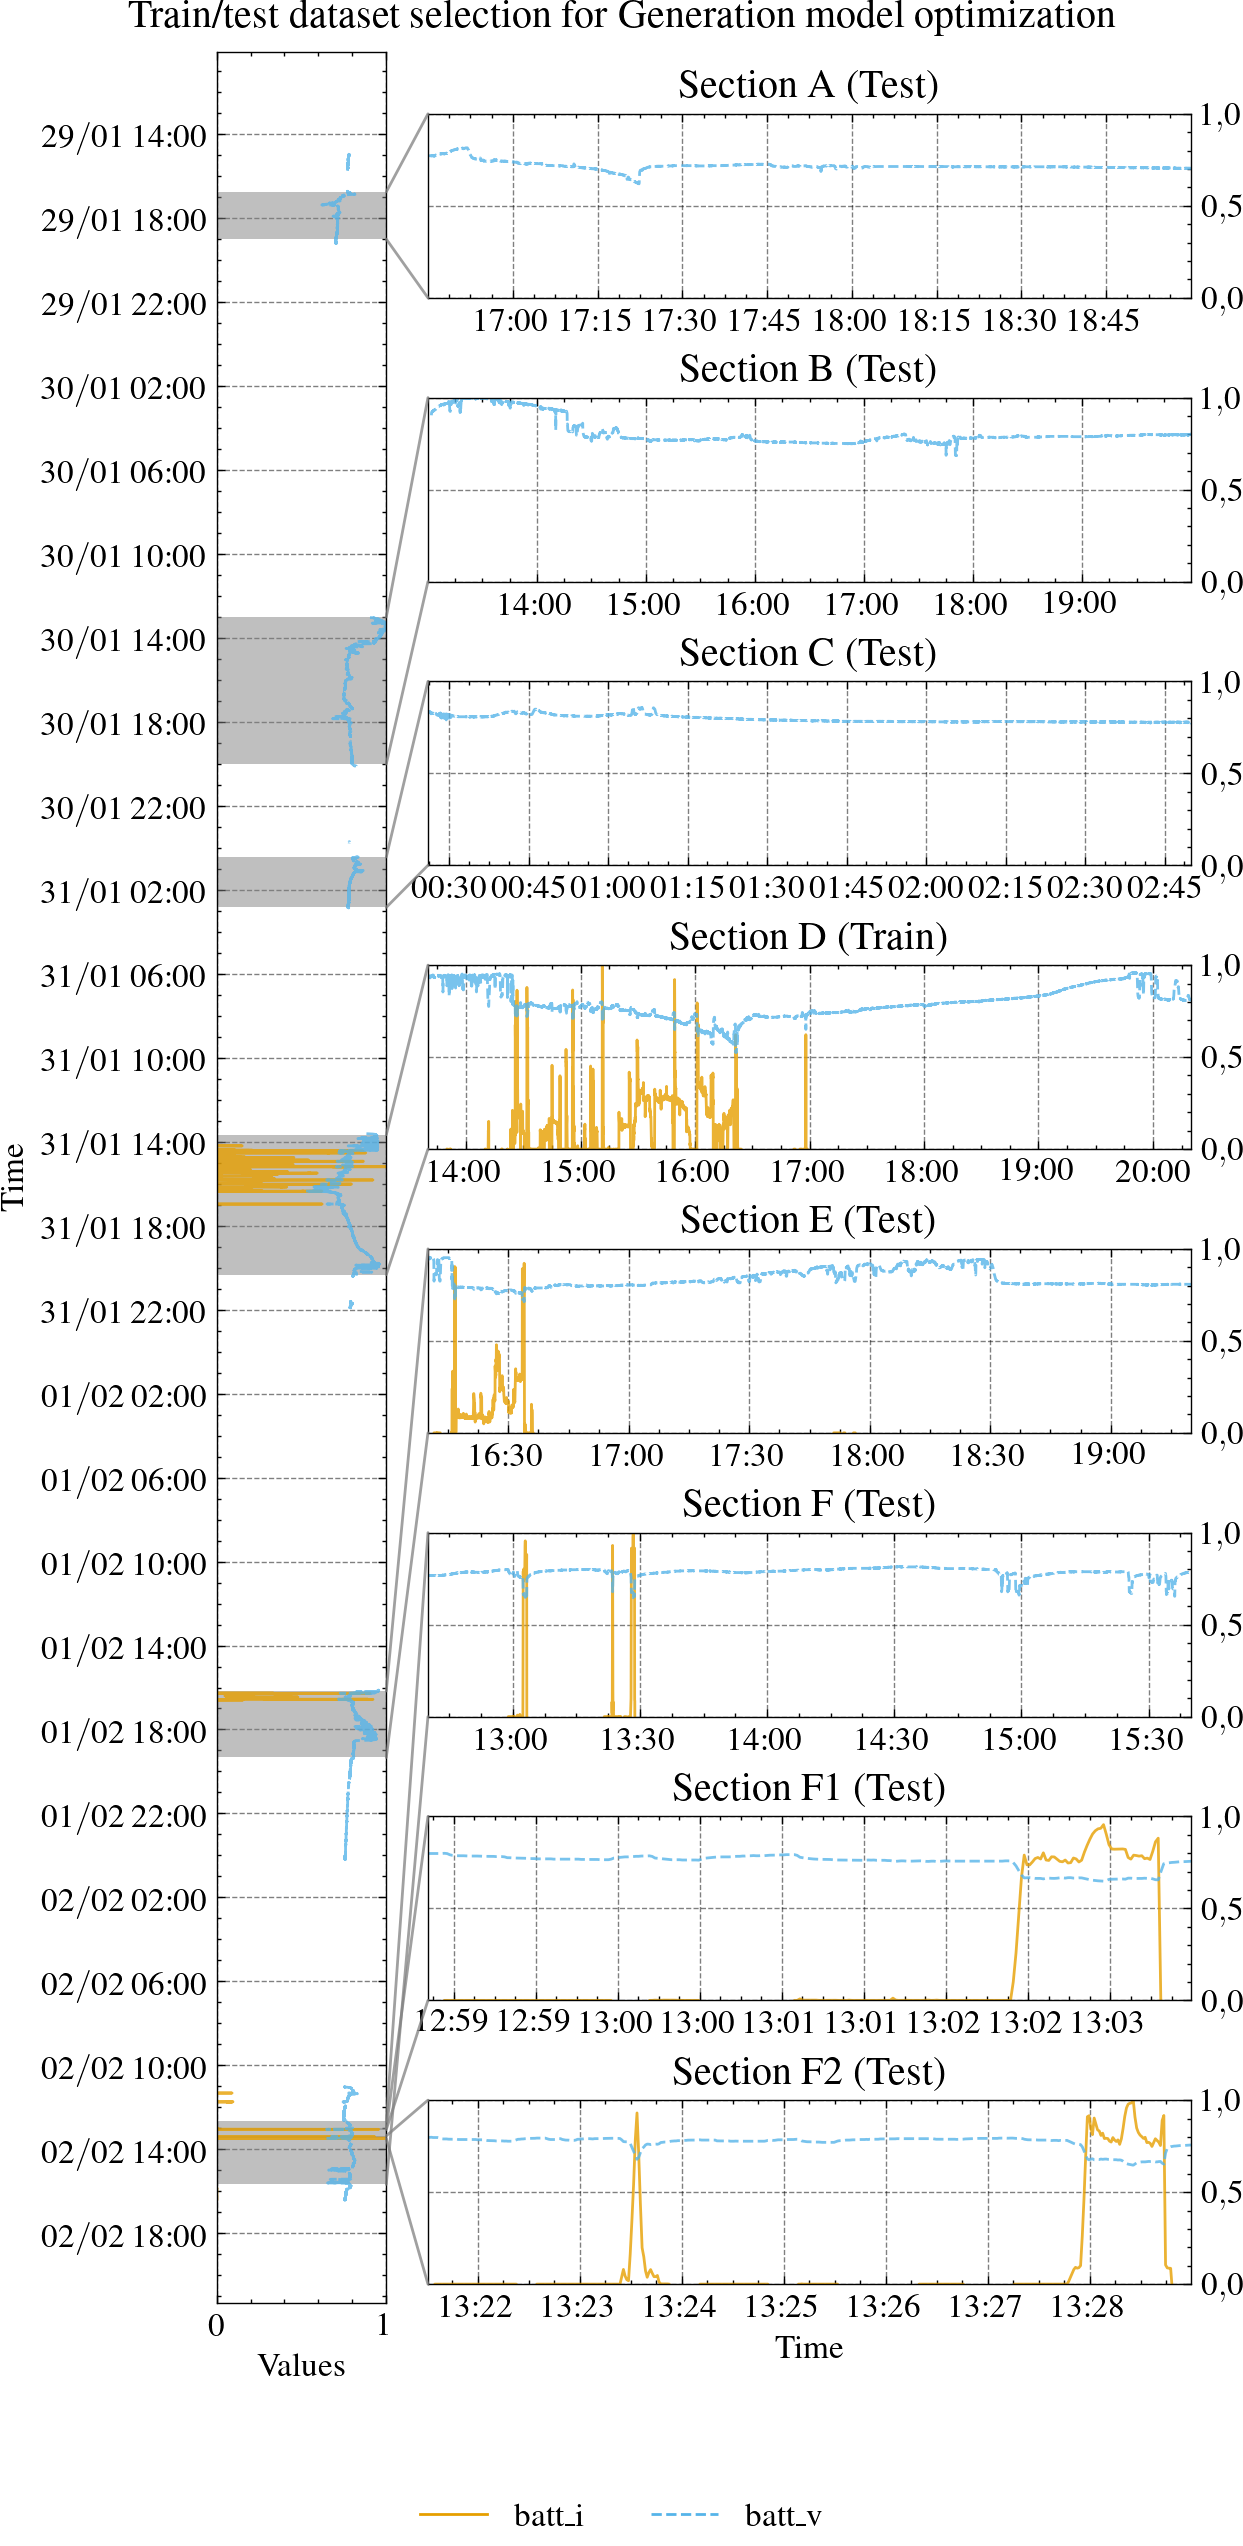

In [3]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
    # 'ESC Duty Cycle': 'pilot_d',
    # 'Motor Angular Speed': 'motor_w',
    # 'ESC Input Power': 'esc_p_in',
    # 'ESC Input Current': 'esc_i_in',
    # **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,5)},
    # **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,5)},
    # **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    # **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,5)},
    # 'MPPTs Output Current': 'mppts_i_out',
    # 'PVs G': 'pv_g',
    # 'Solar POA': 'solar_poa',
    # 'Wind Speed': 'wind_v',
    # 'Air Temperature': 'air_t',
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
    nominal_Q=nominal_Q,
    initial_SOC=initial_SOC
)

sections, tzinfo = get_sections()

# Customizing ranges:
# sections.loc['Section D', 'start'] = pd.Timestamp('2020-01-31 14:20:00')
# sections.loc['Section D', 'end'] = pd.Timestamp('2020-01-31 16:20:00')
# sections.loc['Section E', 'end'] = pd.Timestamp('2020-02-01 16:20:00')
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 12:58:50'), pd.Timestamp('2020-02-02 13:03:30')]
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:29:00')]
# sections = sections.loc[['Section D', 'Section E', 'Section F1', 'Section F2']]

# sections = sections.loc[['Section D', 'Section E', 'Section F']]
train_section_name = 'Section D'
train_test_sections = sections.reset_index().to_dict(orient='records')
train_section = sections.loc[sections.index == train_section_name].reset_index().to_dict(orient='records')[0]
test_sections = sections.loc[sections.index != train_section_name].reset_index().to_dict(orient='records')

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]['name'] == train_section_name:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Train)'
        train_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size
    else:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Test)'
        test_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size


total_size = train_size+test_size
print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
        filename=None,#f'{latex_img_path}/battery_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=['batt_i', 'batt_v'],
            normalize=True,
        )
    )


# Battery Equivalent Circuit Model


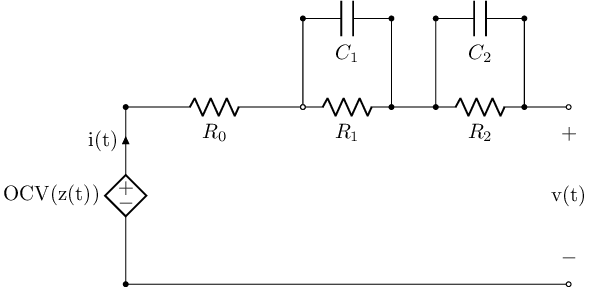

In [4]:
# !pip install lcapy zfitpy pyspice
# %pip install https://github.com/mph-/lcapy/archive/master.zip
# Open `tllocalmgr`, then `install circuitikz`, then `exit`, then `sudo texhash`
import lcapy as lca

circuit_draw_params = dict(
    # help_lines=1,
    # debug=True,
    draw_nodes=True,
    label_nodes=False,
    label_ids=True,
    label_values=False,
    cpt_size=1,
    node_spacing=3,
    scale=1,
    dpi=150,
)

circuit = lca.Circuit("""
E1 R0.1 0 2 0; down, l={OCV(z(t))}, i>={i(t)}
R0 .1 .2; right
R1 R0.2 .2; right=0.5
C1 .1 .2; right=0.5
W R1.1 C1.1; up=0.5
W R1.2 C1.2; up=0.5
W R1.2 R2.1; right=0.25
R2 .1 .2; right=0.5
C2 .1 .2; right=0.5
W R2.1 C2.1; up=0.5
W R2.2 C2.2; up=0.5
W R2.2 P1.1; right=0.25
P1 .1 0_2; down, v={v(t)}
W 0 0_2; right
;""")
circuit.draw(**circuit_draw_params)
circuit.draw(**circuit_draw_params, filename="/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/battery_model_2rc.png")


![](feZkCLr.png)

De acordo com [Mateo Basic](https://www.sciencedirect.com/science/article/pii/S2405896322003469), as seguintes equações representam o sistema da imagem acima, onde $z(t)$ é o estado de carga da bateria:

$$ \begin{aligned}
    \frac{dv_{C_{1}}(t) }{ dt } &=
        -\frac{ v_{C_{1}}(t) }{ R_{1} C_{1} }
        +\frac{ i(t) }{ C_{1} } \\
    \frac{ dv_{C_{0}}(t) }{ dt } &=
        \frac{ i(t) }{ C_{0} } \\
    v(t) &= 
        -v_{C_{0}}
        -v_{C_{1}}
        -R_{0} i(t)
\end{aligned} $$

O estado de carga ($z(t)$) pode ser definido como nas equações abaixo, onde $Q$ é a carga nominal da bateria, e $\eta$, a eficiência culombica:

$$ \begin{aligned}
    z(t) &= 
        z(t_{0}) 
        -\frac{1}{Q} \int_{t_{0}}^t \eta(t) i(t) dt \\
    \frac{dz(t)}{dt} &= 
        -\frac{\eta(t) i(t)}{Q}
\end{aligned} $$

Para que possam ser utilizadas os métodos de solução de sistemas no espaço de estados, podemos separar $VOC(z(t))$ em um modelo externo, considerando-o como uma entrada, deste modo, a função $VOC(z(t))$ pode ser um modelo caixa-preta.

In [5]:
import control as ct
from math import sqrt, pi

class Battery:
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        # Params
        batt_R_1, batt_R_2 = (
            params['batt_R_1'],
            params['batt_R_2'],
        )

        # Input Initial Conditions
        batt_z_0 = X0['batt_z']

        # Inputs
        batt_i_0 = U0[0]  # Battery current [A]

        # Initial condition equations
        batt_v_C_1_0 = batt_i_0 * batt_R_1
        batt_v_C_2_0 = batt_i_0 * batt_R_2

        return np.array([batt_z_0, batt_v_C_1_0, batt_v_C_2_0])

    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params
        batt_eta, batt_Q, batt_R_1, batt_tau_1, batt_R_2, batt_tau_2 = (
            params['batt_eta'],
            params['batt_Q'],
            params['batt_R_1'],
            params['batt_tau_1'],
            params['batt_R_2'],
            params['batt_tau_2'],
        )

        # Inputs
        batt_i = u[0]  # Battery current [A]

        # States
        # batt_z = x[0]  # battery State Of Charge [unitless]
        batt_v_C_1 = x[1]  # battery voltage through the internal serie-parallel resistance [V]
        batt_v_C_2 = x[2]  # battery voltage through the internal serie-parallel resistance [V]

        # System of differential equations
        d_batt_z = -batt_eta * batt_i / batt_Q
        d_batt_v_C_1 = -(batt_v_C_1 / (batt_tau_1)) + (batt_i * batt_R_1 / batt_tau_1)
        d_batt_v_C_2 = -(batt_v_C_2 / (batt_tau_2)) + (batt_i * batt_R_2 / batt_tau_2)

        return np.array([d_batt_z, d_batt_v_C_1, d_batt_v_C_2])

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Params
        batt_R_0, batt_k_V_OC_coeffs = (
            params['batt_R_0'],
            params['batt_k_V_OC_coeffs'],
        )

        # Inputs
        batt_i = u[0]  # Battery current [A]

        # States
        batt_z = x[0]  # battery State Of Charge [unitless]
        batt_v_C_1 = x[1]  # battery voltage through the internal serie-parallel resistance [V]
        batt_v_C_2 = x[2]  # battery voltage through the internal serie-parallel resistance [V]

        # Output equations
        batt_ocv = np.polynomial.Polynomial(batt_k_V_OC_coeffs)(batt_z)
        batt_v = batt_ocv - batt_v_C_1 - batt_v_C_2 - batt_R_0 * batt_i

        return np.array([batt_v, batt_z, batt_ocv])


    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='battery',
            states=('batt_z', 'd_batt_v_C_1', 'd_batt_v_C_2'),
            inputs=('batt_i',),
            outputs=('batt_v', 'batt_z', 'batt_ocv'),
            params=params,
        )

Battery.build({})

<NonlinearIOSystem:battery:['batt_i']->['batt_v', 'batt_z', 'batt_ocv']>

array([  31.50231386,   35.10920712, -143.93021665,  360.36031983,
       -489.66157617,  339.79072398,  -93.87254902])

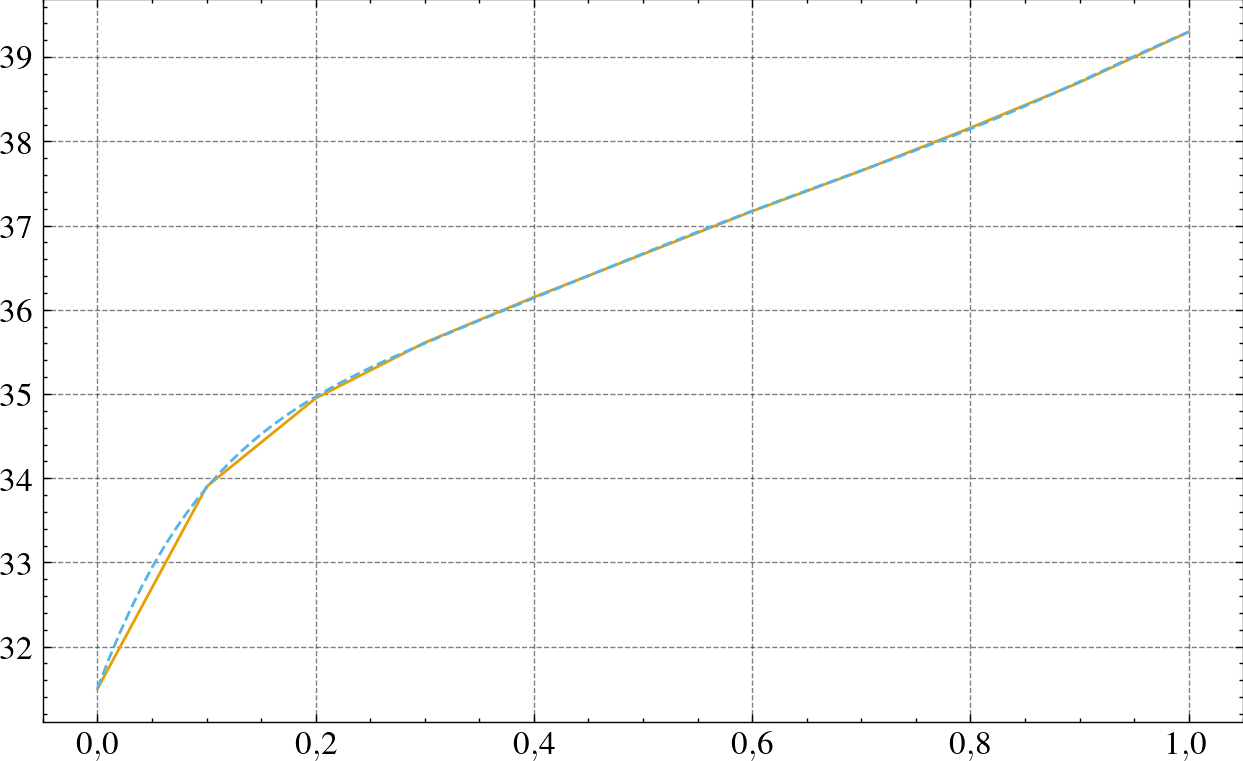

In [6]:
plt.figure()

# From: https://imgv2-2-f.scribdassets.com/img/document/682244176/original/0a169c4659/1730632177?v=1
v = np.array([13.1, 12.9, 12.72, 12.55, 12.39, 12.22, 12.05, 11.87, 11.65, 11.3, 10.5]) * 3
z = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0])
plt.plot(z, v)

deg = 6
batt_k_V_OC_coeffs = np.polynomial.Polynomial.fit(z, v, deg, [0, 1]).convert().coef
display(batt_k_V_OC_coeffs)

z = np.linspace(0, 1, 100)
y_ref = np.polynomial.Polynomial(batt_k_V_OC_coeffs)(z)
plt.plot(z, y_ref)
plt.show()

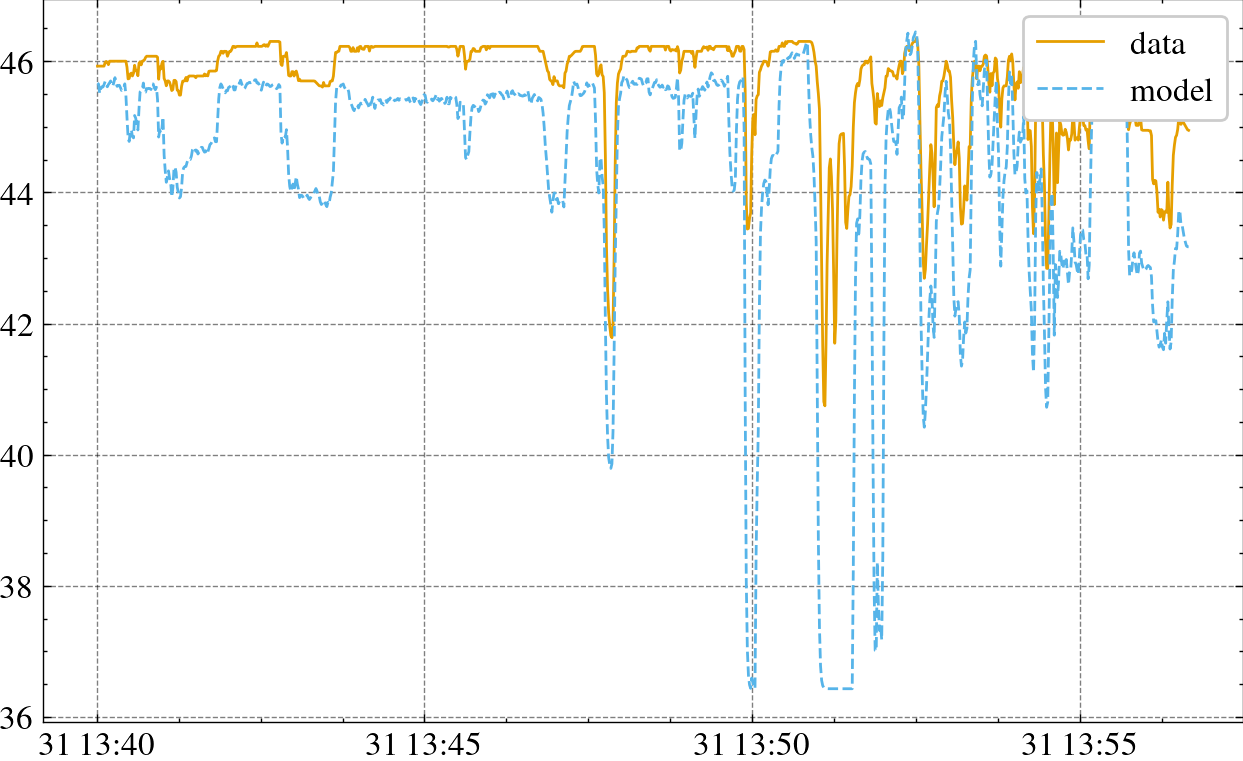

In [7]:
batt_name = 'D35'
cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 1
nominal_voltage = series_cells * cell_voltage

battery_params = {
    'batt_eta': 1,
    'batt_Q': cell_amps_hour * 3600,
    'batt_R_0': 0.1,
    'batt_R_1': 0.5,
    'batt_tau_1': 1,
    'batt_R_2': 1e-3,
    'batt_tau_2': 1,
    'batt_k_V_OC_coeffs': batt_k_V_OC_coeffs,
}

# Select the optimization data
data_cols = ['batt_v']
input_cols = ['batt_i']

df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols][:1000]

# Time array
T = df_train['t'].to_numpy()

# Inputs
U = df_train[['batt_i']].to_numpy().T

# Model
battery = Battery.build(battery_params)

# Initial state
X0 = Battery.initial_state(X0={'batt_z': 0.4}, U0=U[:,0], params=battery_params)

# Simulation
res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

plt.plot(df_train.index, df_train['batt_v'], label='data')
plt.plot(df_train.index, ydata['batt_v'], label='model')
plt.legend(loc='upper right')
plt.show()

# Sensitivity Analysis

In [8]:
from SALib import ProblemSpec

import warnings
warnings.filterwarnings("ignore")


def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Battery.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()


def battery_sensitivity_analysis_discharge_case(
    T: np.array,
    params_bounds: dict,
    discharge_rate: float,
    initial_SOC: float,
    do_plot=True,
    do_display=True
):
    # discharge_rate: 10 means it's dicharging at 10C, -5 means it's charging at 5C
    discharge_current = nominal_Q * discharge_rate

    model_params = battery_params
    model = Battery
    model_tmp = model.build({})

    sp = ProblemSpec({
        "names":  list(params_bounds.keys()),
        "bounds": [(p['min'], p['max']) for p in params_bounds.values()],
        "outputs": model_tmp.output_labels,
        'dists': [p['dist'] for p in params_bounds.values()],
        'groups': [p.get('group') or name for name, p in params_bounds.items()],
        "seed": 42,
    })

    # Initial state
    X0 = np.zeros(model_tmp.nstates)
    X0[model_tmp.state_labels.index('batt_z')] = initial_SOC
    X0[battery.state_index['d_batt_v_C_1']] = df_train['batt_i'][0] * battery_params['batt_R_1']
    X0[battery.state_index['d_batt_v_C_2']] = df_train['batt_i'][0] * battery_params['batt_R_2']

    # Input data
    U = np.empty([model_tmp.ninputs, len(T)]) * np.nan # nan to force us to define every input
    U[model_tmp.input_labels.index('batt_i')] = discharge_current

    df_sa = sensitivity_analysis(
        T=T,
        U=U,
        X0=X0,
        model_function=model_function,
        model_class=model,
        model_params=model_params,
        problem=sp,
        sample_size=2**12*len(sp["groups"]),
        nprocs=32,
        analyze_kwargs=dict(
            parallel=True,
            n_processors=12
        ),
    )
    if do_display: display(df_sa)

    df_sac = consolidate_sa_results(df_sa)
    if do_display: display(df_sac.dropna())
    if do_display: display(df_sac.dropna().pivot(index=['Output', 'Factor'], columns='Order', values=['Mean', 'Mean Conf']))

    if do_plot:
        for output in df_sa['output'].unique():
            fig_save_and_show(
                # f'{latex_img_path}/battery_sensibility_analysis_time.pdf',
                None,
                f'Sensibilidade da saída {output} do modelo da bateria aos seus parâmetros no tempo',
                f'Sensitivity of the battery model\noutput {output} to parameters over time',
                fig=plot_sensitivity_analysis(df_sa, output),
            )

        for output in df_sa['output'].unique():
            fig_save_and_show(
                # f'{latex_img_path}/battery_sensibility_analysis_steady_state.pdf',
                None,
                f'Sensibilidade da saída {output} do modelo da bateria aos seus parâmetros no tempo ',
                f'Sensitivity of the battery model\noutput {output} to parameters over time',
                fig=plot_sensitivity_heatmaps(df_sa, output),
            )

        fig_save_and_show(
            # f'{latex_img_path}/battery_sensibility_analysis_steady_state_second_order.pdf',
            None,
            f'Sensibilidade das saídas do modelo da bateria aos seus parâmetros em regime permanente ',
            f'Second-Order Sensitivity Analysis for steady state',
            fig=plot_sensitivity_analysis_second_order(df_sa),
        )

    return df_sa, df_sac


params_bounds = {
    'batt_R_0': dict(min=1e-6, max=1, dist='logunif', group=None),
    'batt_R_1': dict(min=1e-6, max=1, dist='logunif', group=None),
    'batt_C_1': dict(min=1, max=1e3, dist='logunif', group=None),
    'batt_R_2': dict(min=1e-6, max=1e3, dist='logunif', group=None),
    'batt_C_2': dict(min=1e3, max=1e9, dist='logunif', group=None),
    'batt_eta': dict(min=0.1, max=1, dist='unif', group=None),
}
n_coeffs = 5
for i in range(0, n_coeffs):
    params_bounds[f'batt_ocv_coeff_{i}'] = dict(min=-100, max=100, dist='logunif', group='batt_k_V_OC_coeffs')

display(params_bounds)

{'batt_R_0': {'min': 1e-06, 'max': 1, 'dist': 'logunif', 'group': None},
 'batt_R_1': {'min': 1e-06, 'max': 1, 'dist': 'logunif', 'group': None},
 'batt_C_1': {'min': 1, 'max': 1000.0, 'dist': 'logunif', 'group': None},
 'batt_R_2': {'min': 1e-06, 'max': 1000.0, 'dist': 'logunif', 'group': None},
 'batt_C_2': {'min': 1000.0,
  'max': 1000000000.0,
  'dist': 'logunif',
  'group': None},
 'batt_eta': {'min': 0.1, 'max': 1, 'dist': 'unif', 'group': None},
 'batt_ocv_coeff_0': {'min': -100,
  'max': 100,
  'dist': 'logunif',
  'group': 'batt_k_V_OC_coeffs'},
 'batt_ocv_coeff_1': {'min': -100,
  'max': 100,
  'dist': 'logunif',
  'group': 'batt_k_V_OC_coeffs'},
 'batt_ocv_coeff_2': {'min': -100,
  'max': 100,
  'dist': 'logunif',
  'group': 'batt_k_V_OC_coeffs'},
 'batt_ocv_coeff_3': {'min': -100,
  'max': 100,
  'dist': 'logunif',
  'group': 'batt_k_V_OC_coeffs'},
 'batt_ocv_coeff_4': {'min': -100,
  'max': 100,
  'dist': 'logunif',
  'group': 'batt_k_V_OC_coeffs'}}

In [9]:
# %%time
# ## BATTERY SENSIVITY ANALYSIS: DISCHARGE @ 1C

# # Since the test will take an hour, and it's quite monotonous, we can have just a few samples
# df_sa, df_sac = battery_sensitivity_analysis_discharge_case(
#     T=np.linspace(0, 3600, 11, endpoint=True),
#     params_bounds=params_bounds,
#     discharge_rate=1,
#     initial_SOC=1,
#     do_plot=True,
#     do_display=True,
# )

In [10]:
# %%time
# ## BATTERY SENSIVITY ANALYSIS: CHARGE @ 1C

# df_sa, df_sac = battery_sensitivity_analysis_discharge_case(
#     T=np.linspace(0, 3600, 11, endpoint=True),
#     params_bounds=params_bounds,
#     discharge_rate=-1,
#     initial_SOC=0,
#     do_plot=True,
#     do_display=True,
# )

In [11]:
# %%time
# ## BATTERY SENSIVITY ANALYSIS: HIGH CURRENT PEAKS

# def battery_sensitivity_analysis_arbitrary_current_signal(
#     T: np.array,
#     current_signal: np.array,
#     params_bounds: dict,
#     discharge_rate: float,
#     initial_SOC: float,
#     do_plot=True,
#     do_display=True
# ):
#     model_params = battery_params
#     model = Battery
#     model_tmp = model.build({})

#     sp = ProblemSpec({
#         "names":  list(params_bounds.keys()),
#         "bounds": [(p['min'], p['max']) for p in params_bounds.values()],
#         "outputs": model_tmp.output_labels,
#         'dists': [p['dist'] for p in params_bounds.values()],
#         'groups': [p.get('group') or name for name, p in params_bounds.items()],
#         "seed": 42,
#     })

#     # # Initial state
#     X0 = np.zeros(model_tmp.nstates)
#     X0[model_tmp.state_labels.index('batt_z')] = initial_SOC

#     # # If we are discharging
#     U = np.empty([model_tmp.ninputs, len(T)]) * np.nan # nan to force us to define every input
#     U[model_tmp.input_labels.index('batt_i')] = current_signal

#     df_sa = sensitivity_analysis(
#         T=T,
#         U=U,
#         X0=X0,
#         model_function=model_function,
#         model_class=model,
#         model_params=model_params,
#         problem=sp,
#         sample_size=2**12*len(sp["groups"]),
#         nprocs=32,
#         analyze_kwargs=dict(
#             parallel=False,
#             n_processors=4
#         ),
#     )
#     if do_display: display(df_sa)

#     df_sac = consolidate_sa_results(df_sa)
#     if do_display: display(df_sac.dropna())
#     if do_display: display(df_sac.dropna().pivot(index=['Output', 'Factor'], columns='Order', values=['Mean', 'Mean Conf']))

#     if do_plot:
#         for output in df_sa['output'].unique():
#             fig_save_and_show(
#                 # f'{latex_img_path}/battery_sensibility_analysis_time.pdf',
#                 None,
#                 f'Sensibilidade da saída {output} do modelo da bateria aos seus parâmetros no tempo',
#                 f'Sensitivity of the battery model\noutput {output} to parameters over time',
#                 fig=plot_sensitivity_analysis(df_sa, output),
#             )

#         for output in df_sa['output'].unique():
#             fig_save_and_show(
#                 # f'{latex_img_path}/battery_sensibility_analysis_steady_state.pdf',
#                 None,
#                 f'Sensibilidade da saída {output} do modelo da bateria aos seus parâmetros no tempo ',
#                 f'Sensitivity of the battery model\noutput {output} to parameters over time',
#                 fig=plot_sensitivity_heatmaps(df_sa, output),
#             )

#         fig_save_and_show(
#             # f'{latex_img_path}/battery_sensibility_analysis_steady_state_second_order.pdf',
#             None,
#             f'Sensibilidade das saídas do modelo da bateria aos seus parâmetros em regime permanente ',
#             f'Second-Order Sensitivity Analysis for steady state',
#             fig=plot_sensitivity_analysis_second_order(df_sa),
#         )

#     return df_sa, df_sac

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import signal

# T = np.linspace(0, 100, 101, endpoint=True)
# peak = 100
# frequency = 0.02
# duty_cycle = 0.25
# phase = - np.pi / 2
# batt_i = (0.5 + signal.square(phase + 2 * np.pi * frequency * T, duty=duty_cycle) / 2) * peak

# plt.plot(T, batt_i)
# plt.xlabel("Time [s]")
# plt.ylabel("Current [A]")
# plt.suptitle("Battery current over time")
# plt.grid(True)
# plt.show()

# df_sa, df_sac = battery_sensitivity_analysis_arbitrary_current_signal(
#     T=T,
#     current_signal=batt_i,
#     params_bounds=params_bounds,
#     discharge_rate=-1,
#     initial_SOC=1,
#     do_plot=True,
#     do_display=True,
# )

# PyBamm

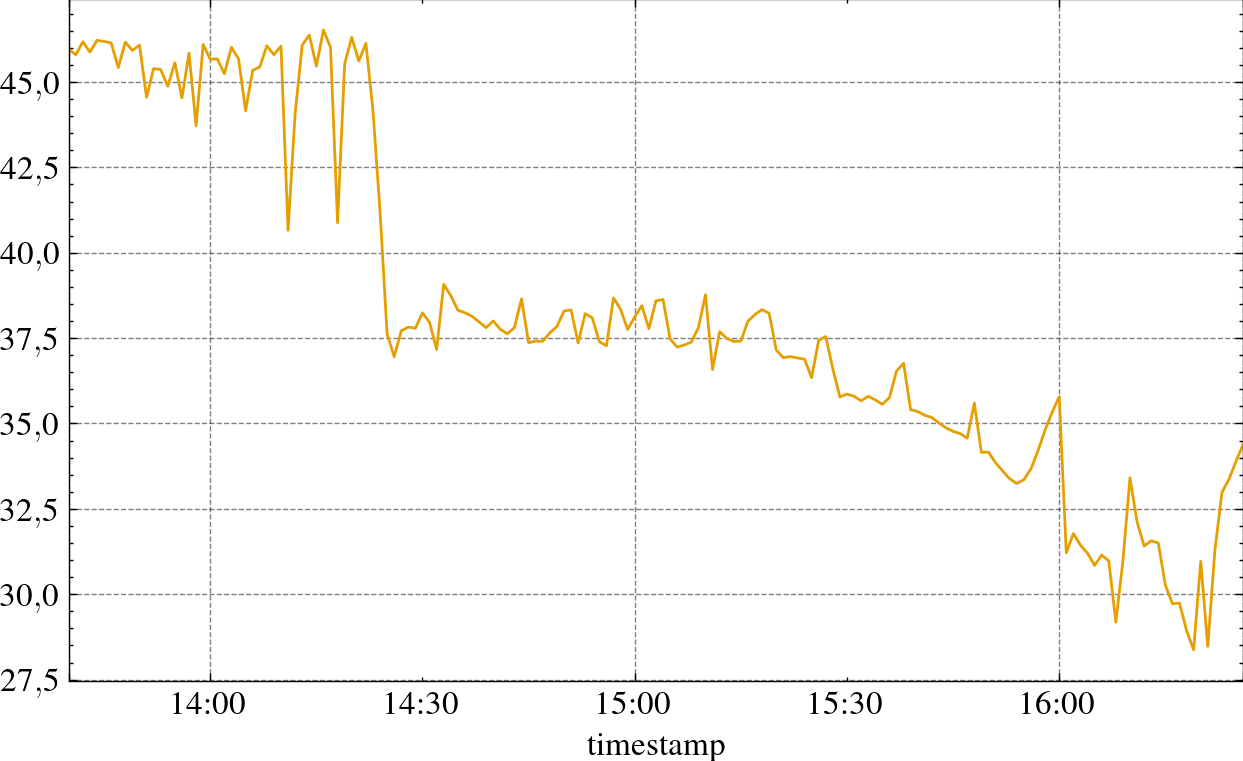

In [12]:
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end'])][:10000].resample('1min').mean().interpolate(method='time')

df_train['batt_v'].plot()
plt.show()

In [14]:
# %pip install pybamm

In [17]:
# %%time

import pybamm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get time data (in seconds) from the DataFrame.
time_data = df_train["t"].to_numpy()
time_data -= time_data[0]
current_data = df_train["batt_i"].to_numpy()

current_interpolant = pybamm.Interpolant(time_data, current_data, pybamm.t, interpolator='linear', extrapolate=False)

parameter_set = pybamm.ParameterValues("ECM_Example")
parameter_set.update(
    {
        "Cell capacity [A.h]": 48,
        "Nominal cell capacity [A.h]": 48,
        "Current function [A]": current_interpolant,
        "Initial SoC": 0.8,
        "Element-1 initial overpotential [V]": 0,
        "Upper voltage cut-off [V]": 3*16,
        "Lower voltage cut-off [V]": 3*10.5,
        "R0 [Ohm]": 1e-3,
        "R1 [Ohm]": 2e-4,
        "C1 [F]": 1e4,
        "Open-circuit voltage [V]": 3*13.1,
    }
)
# Optional arguments - only needed for two RC pairs
parameter_set.update(
    {
        "R2 [Ohm]": 0.0003,
        "C2 [F]": 40000,
        "Element-2 initial overpotential [V]": 0,
    },
    check_already_exists=False,
)

model = pybamm.equivalent_circuit.Thevenin(options={
    "number of rc elements": 1,
    "calculate discharge energy": "false",
    "diffusion element": "false",
    "operating mode": "current",
})

# Process the parameters and geometry for the model.
parameter_set.process_model(model)
geometry = model.default_geometry
parameter_set.process_geometry(geometry)

# Discretise the model using the default mesh and spatial methods.
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

# solver = pybamm.CasadiSolver(mode="fast")
# solver = pybamm.ScipySolver(method="Radau", extra_options=dict(max_step=1))
# solver = pybamm.IDAKLUSolver()
solver = pybamm.JaxSolver()

# Solve the model.
solution = solver.solve(model, time_data, inputs={"Current function [A]": current_interpolant})

if True:
    voltage = solution["Battery voltage [V]"].entries
    current = solution["Current [A]"].entries
    time_hours = solution["Time [h]"].entries
    ocv = solution["Open-circuit voltage [V]"].entries
    soc = solution["SoC"].entries

    # Plot the results: battery voltage and SOC over time.
    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    plt.plot(time_hours, current, label="Current [A]")
    plt.xlabel("Time [h]")
    plt.ylabel("Current [A]")
    plt.title("Battery Pack Current over Time")
    plt.legend()
    plt.subplot(3, 1, 2)
    plt.plot(time_hours, voltage, label="Voltage [V]")
    plt.plot(time_hours, df_train['batt_v'], label="Voltage [V]")
    plt.xlabel("Time [h]")
    plt.ylabel("Voltage [V]")
    plt.title("Battery Pack Voltage over Time")
    plt.legend()
    plt.subplot(3, 1, 3)
    plt.plot(time_hours, soc, color="tab:orange", label="State of Charge")
    plt.xlabel("Time [h]")
    plt.ylabel("SOC")
    plt.title("State of Charge over Time")
    plt.legend()
    plt.show()

    # Plot OCV vs SOC
    plt.figure(figsize=(6, 4))
    plt.plot(soc, ocv, label="Simulated OCV(SOC)")
    plt.xlabel("State of Charge (SOC)")
    plt.ylabel("Open Circuit Voltage (V)")
    plt.title("Open Circuit Voltage vs. SOC from Simulation")
    plt.legend()
    plt.grid()
    plt.show()


ModuleNotFoundError: Jax or jaxlib is not installed, please see https://docs.pybamm.org/en/latest/source/user_guide/installation/gnu-linux-mac.html#optional-jaxsolver

# Optimization

In [198]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Battery.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

In [199]:
# train_section['start'] = pd.Timestamp(year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo).tz_convert(None)
# train_section['end'] = pd.Timestamp(year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo).tz_convert(None)

battery_params['batt_R_0'] = series_cells * 0.003 # from: http://raetech.com.sg/optima_yellow_specs.html

In [200]:
def estimate_polynomial_coefficient_bounds(x_interval, y_bounds, degree, grid_points=1000):
    """
    Estimate bounds for each coefficient a_j (j = 0, ..., degree) of a polynomial
      p(x) = a_0 + a_1*x + ... + a_degree*x^degree
    subject to:
      y_min <= p(x) <= y_max  for all x in [x_min, x_max].

    The "for all x" constraint is approximated by enforcing the constraints on a dense grid.

    Parameters:
        x_interval : tuple (x_min, x_max)
        y_bounds   : tuple (y_min, y_max)
        degree     : int, degree of the polynomial (there are degree+1 coefficients)
        grid_points: int, number of grid points in [x_min, x_max] for discretization.

    Returns:
        bounds: list of tuples [(a_0_min, a_0_max), (a_1_min, a_1_max), ...]
    """
    from scipy.optimize import linprog

    x_min, x_max = x_interval
    y_min, y_max = y_bounds

    # Create a dense grid on the x interval.
    x_grid = np.linspace(x_min, x_max, grid_points)
    M = grid_points

    # Build the design matrix: each row corresponds to an x value.
    # Each row is [1, x, x^2, ..., x^degree]
    X = np.vstack([x_grid**i for i in range(degree + 1)]).T  # shape: (M, degree+1)

    # Set up inequality constraints.
    # For each x in x_grid, we require:
    #    a_0 + a_1*x + ... + a_degree*x^degree <= y_max   and
    #   -a_0 - a_1*x - ... - a_degree*x^degree <= -y_min  (i.e. p(x) >= y_min)
    A_upper = X          # p(x) <= y_max
    A_lower = -X         # -p(x) <= -y_min
    A_ub = np.vstack([A_upper, A_lower])  # Combined constraint matrix
    b_upper = np.full(M, y_max)
    b_lower = np.full(M, -y_min)
    b_ub = np.concatenate([b_upper, b_lower])

    # Prepare a list to hold the computed bounds.
    bounds_list = []

    # For each coefficient index j, solve two LPs: one to maximize a_j, one to minimize a_j.
    for j in range(degree + 1):
        # --- Maximize a_j:  maximize a_j  <=> minimize -a_j ---
        # Objective: minimize c^T a, where c[j] = -1 and all other entries are 0.
        c_max = np.zeros(degree + 1)
        c_max[j] = -1  # maximize a_j by minimizing -a_j.
        res_max = linprog(c=c_max, A_ub=A_ub, b_ub=b_ub,
                          bounds=[(None, None)] * (degree + 1), method='highs')
        if not res_max.success:
            raise RuntimeError(f"LP maximizing coefficient a_{j} failed: {res_max.message}")
        a_j_max = res_max.x[j]

        # --- Minimize a_j: objective is to minimize a_j ---
        c_min = np.zeros(degree + 1)
        c_min[j] = 1
        res_min = linprog(c=c_min, A_ub=A_ub, b_ub=b_ub,
                          bounds=[(None, None)] * (degree + 1), method='highs')
        if not res_min.success:
            raise RuntimeError(f"LP minimizing coefficient a_{j} failed: {res_min.message}")
        a_j_min = res_min.x[j]

        bounds_list.append((a_j_min, a_j_max))

    return bounds_list

n_coeffs = 2
coeff_bounds = estimate_polynomial_coefficient_bounds(x_interval=(0, 1), y_bounds=(20, 60), degree=(n_coeffs-1))
coeff_bounds

In [201]:
batt_k_V_OC_coeffs

array([  31.50231386,   35.10920712, -143.93021665,  360.36031983,
       -489.66157617,  339.79072398,  -93.87254902])

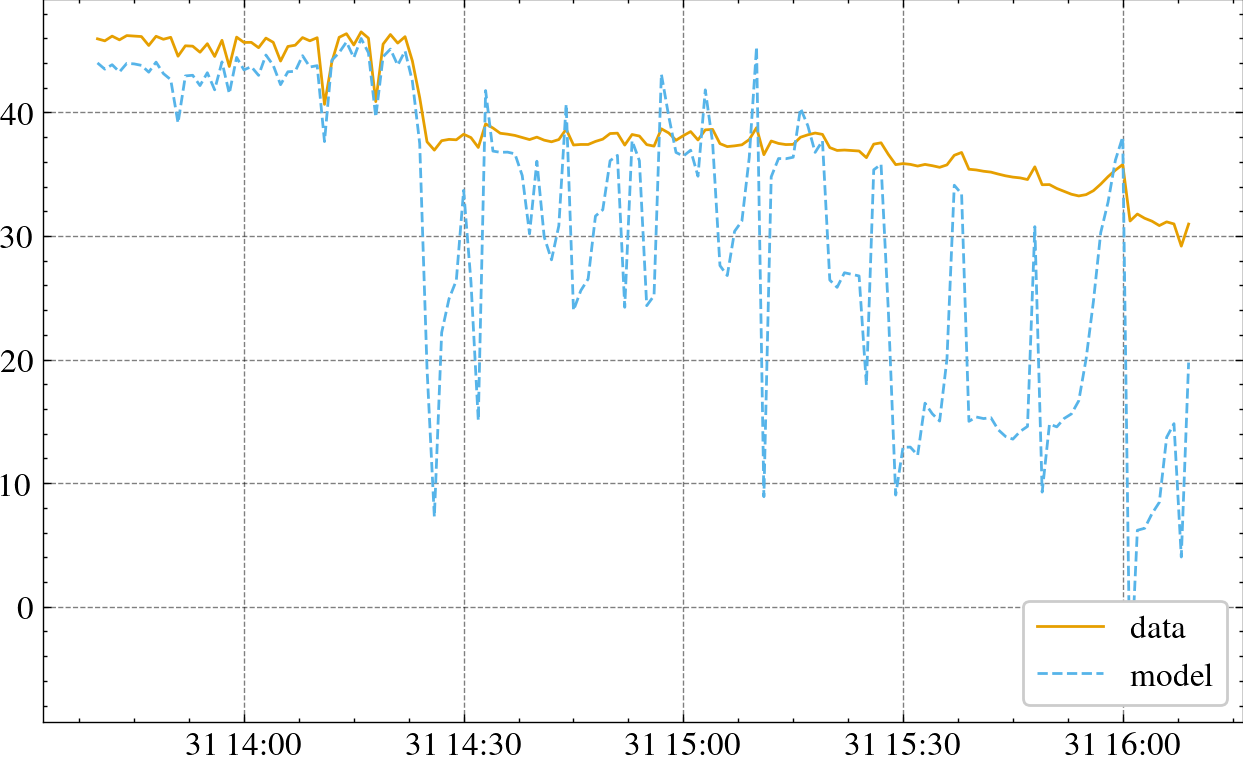

In [249]:
# battery_params['batt_k_V_OC_coeffs'] = np.array([33, 10])
battery_params['batt_k_V_OC_coeffs'] = batt_k_V_OC_coeffs

df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols][:9000].resample('1min').mean().interpolate(method='time')

# Time array
T = df_train['t'].to_numpy()

# Inputs
U = df_train[['batt_i']].to_numpy().T

# Model
battery = Battery.build(battery_params)

# Initial state
X0 = Battery.initial_state(X0={'batt_z': 0.4}, U0=U[:,0], params=battery_params)

# Simulation
res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

plt.plot(df_train.index, df_train['batt_v'].to_numpy(), label='data')
plt.plot(df_train.index, ydata['batt_v'].to_numpy(), label='model')
plt.legend(loc='lower right')
plt.show()

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       20 |  0.2751413005 |  0.0619194928
     2 |       25 |  0.0659966799 |  0.0607481948
     3 |       32 |  0.0655465096 |  0.0609746677
     4 |       34 |  0.0608411000 |  0.0484042990
     5 |       35 |  0.0584275316 |  0.0484042990
     6 |       36 |  0.0559654907 |  0.0484042990
     7 |       38 |  0.0527694902 |  0.0434043561
     8 |       40 |  0.0485081597 |  0.0363515100
     9 |       42 |  0.0430717123 |  0.0283559829
    10 |       43 |  0.0393508807 |  0.0283559829
    11 |       45 |  0.0350111884 |  0.0234131658
    12 |       47 |  0.0298950227 |  0.0177073046
    13 |       49 |  0.0247273585 |  0.0123983705
    14 |       51 |  0.0204056038 |  0.0104209824
    15 |       52 |  0.0174298809 |  0.0104209824
    16 |       53 |  0.0144666168 |  0.0104209824
    17 |       54 |  0.0123739257 |  0.0104209824
    18 |       55 |  0.0112110521 |  0.0104209824
    19 |       56 |  0.0109455150 |  0.0104209824


{'batt_R_0': 0.009000000000000001,
 'batt_R_1': 0.5,
 'batt_R_2': 0.001,
 'batt_tau_1': 1,
 'batt_tau_2': 1}

Best parameters found:


{'batt_R_0': 0.08719426113553037,
 'batt_R_1': 0.003098002787719484,
 'batt_R_2': 0.26404162168975265,
 'batt_tau_1': 33241.50376145484,
 'batt_tau_2': 4257.689824458155}

Objective value at solution: [0.01007495]


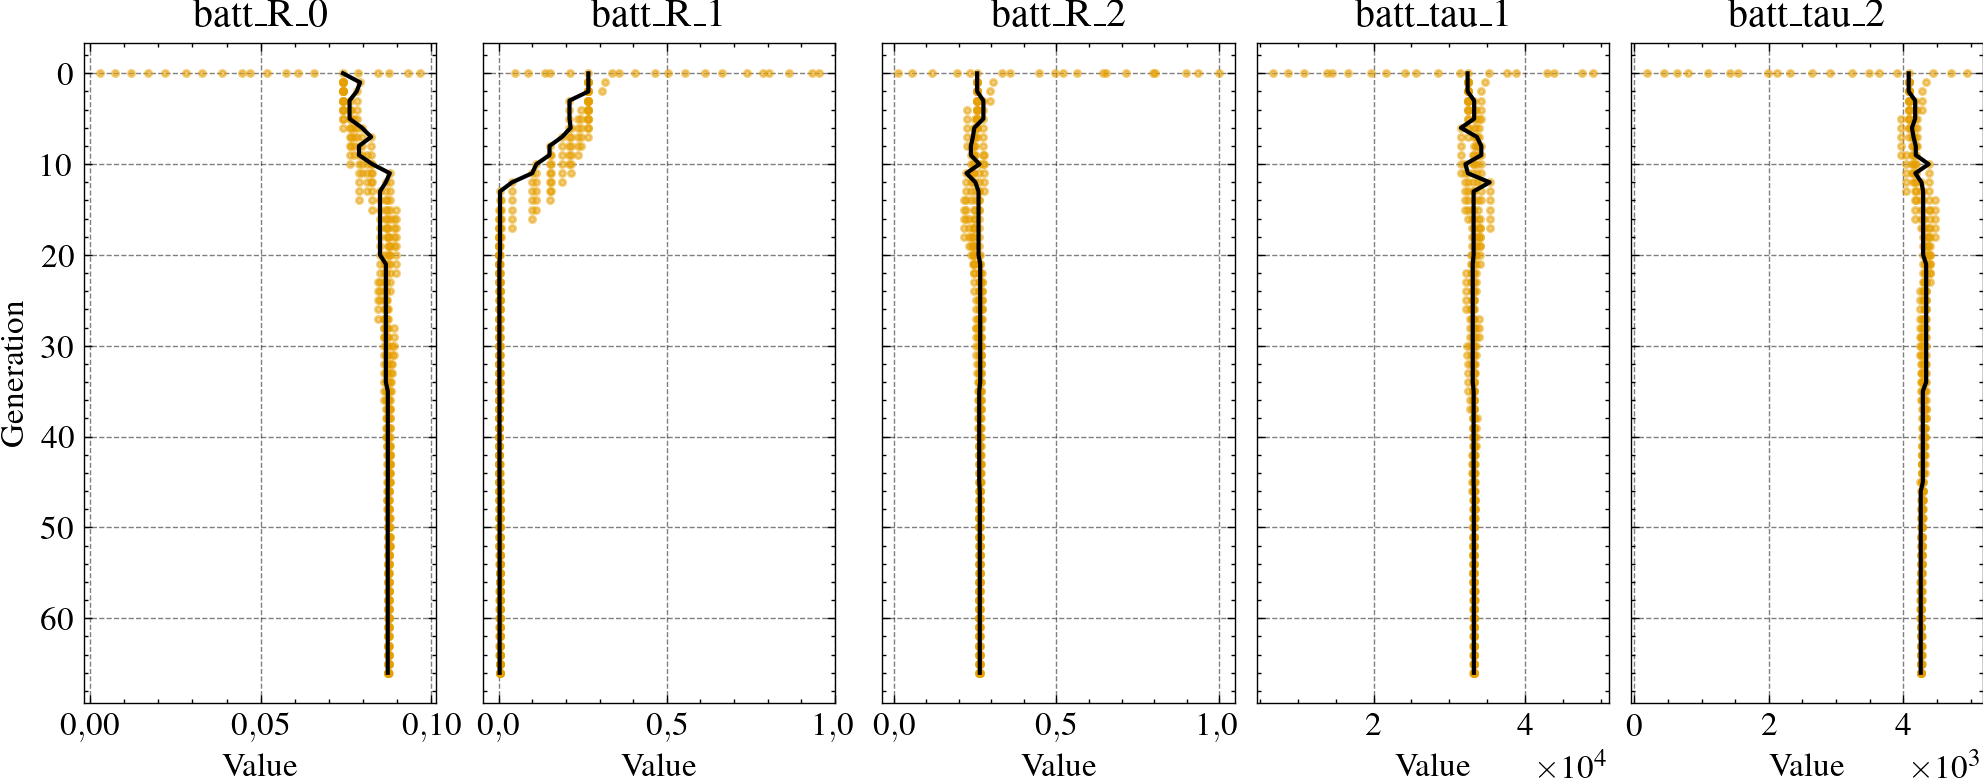

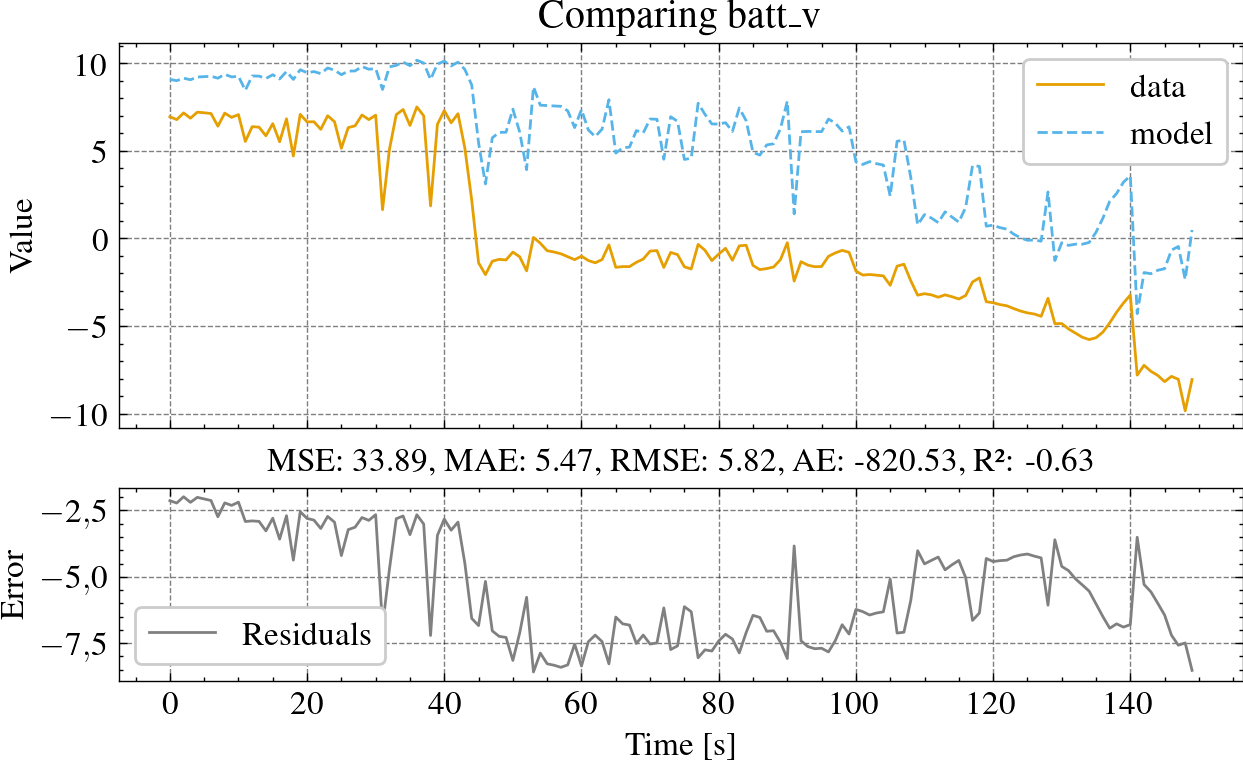

CPU times: user 1.68 s, sys: 2.35 s, total: 4.03 s
Wall time: 11 s


In [261]:
%%time
## BATTERY OPTIMIZATION

# Select the optimization data
# data_cols = ['batt_v', 'batt_z']
data_cols = ['batt_v']
input_cols = ['batt_i']

# Put simulation data into df
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols][:9000].resample('1min').mean().interpolate(method='time')
compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
compute_df_soc(df_train, nominal_Q, inplace=True)
df_train['batt_z'] = (df_train['batt_z'] - df_train['batt_z'].min()) / (df_train['batt_z'].max() - df_train['batt_z'].min())

# Set model states initial conditions
batt_z_0 = df_train['batt_z'][0]
input_initial_state = {'batt_z': batt_z_0}

battery_params['batt_k_V_OC_coeffs'] = np.array([0])
df_train['batt_v'] -= df_train['batt_v'].mean()

# Initialize Parameters
params_bounds = {
    'batt_R_0': dict(min=1e-4, max=0.1),
    'batt_R_1': dict(min=1e-6, max=1),
    'batt_R_2': dict(min=1e-6, max=1),
    'batt_tau_1': dict(min=5000, max=50000),
    'batt_tau_2': dict(min=1, max=5000),
    # 'batt_eta': dict(min=0.1, max=1.0),
}
# n_coeffs = 2
# coeff_bounds = estimate_polynomial_coefficient_bounds(x_interval=(0, 1), y_bounds=y_bounds_estimated, degree=(n_coeffs-1))
# for i in range(0, n_coeffs):
#     params_bounds[f'batt_ocv_coeff_{i}'] = dict(min=coeff_bounds[i][0], max=coeff_bounds[i][1])

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

# Initialize the problem
model = Battery
model_params = battery_params
problem = MyOptimizationProblem(
    model=model,
    model_function=model_function,
    training_data=df_train,
    training_data_columns=data_cols,
    model_params=model_params,
    opt_params_bounds=params_bounds,
    input_initial_state=input_initial_state,
    input_columns=input_cols,
    data_scaler=MinMaxScaler,
    elementwise_runner=runner,
)

algorithm = ISRES(n_offsprings=10*len(params_bounds), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
algorithm = NelderMead()
# algorithm = DE(
#     pop_size=10*len(params_bounds),
#     sampling=LHS(),
#     variant="DE/rand/1/bin",
#     F=0.2,
#     CR=0.9,
# )

# Specify termination criteria (optional)
termination = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=20,
    n_max_gen=10000,
    n_max_evals=100000
)

# Run the optimization
result = minimize(
    problem,
    algorithm,
    termination=termination,
    seed=42,
    verbose=True,
    save_history=True,
)
print('Threads:', result.exec_time)
pool.close()
pool.join()

# Print the results
best_params = convert_to_model_params({k: result.X[i] for (i, k) in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result, params_bounds)
# plot_optimization_error(result, params_bounds)

T = df_train['t'].to_numpy()
U = df_train[input_cols].to_numpy().T
model_tmp = model.build({})
X0 = Battery.initial_state(X0={'batt_z': batt_z_0}, U0=U[:,0], params=battery_params)

best_fit_data = model_function(T, U, X0, **(model_params | best_params))

for col in data_cols:
    plot_compare(df_train, best_fit_data, col)

if 'batt_k_V_OC_coeffs' in best_params.keys():
    soc_test = np.linspace(0, 1, 101, endpoint=True)
    plt.plot(soc_test, np.polynomial.Polynomial(original_params['batt_k_V_OC_coeffs'])(soc_test)/3, label='original')
    plt.plot(soc_test, np.polynomial.Polynomial(best_params['batt_k_V_OC_coeffs'])(soc_test)/3, label='best1')
    plt.legend()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
from sklearn.preprocessing import MinMaxScaler
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE

# =============================================================================
# Part 1. Extract the battery optimization code into a function.
# =============================================================================

def battery_optimization(tau1_bounds, tau2_bounds, df, battery_params, train_section, nominal_Q, initial_SOC):
    """
    Run the battery optimization using the provided tau bounds.

    Parameters:
      tau1_bounds: tuple (tau1_min, tau1_max) for batt_tau_1
      tau2_bounds: tuple (tau2_min, tau2_max) for batt_tau_2
      df: DataFrame with the raw data (must include 't', 'batt_v', 'batt_i', etc.)
      battery_params: dictionary with battery model parameters.
      train_section: dict with keys 'start' and 'end' defining the training section.
      nominal_Q: nominal capacity (used in compute_df_capacity)
      initial_SOC: initial state of charge (used in compute_df_capacity)

    Returns:
      Objective function value (e.g. the residual error) from the optimization.
    """

    # --- Prepare the training data ---
    data_cols = ['batt_v']
    input_cols = ['batt_i']

    # Select the simulation data (here only a subset is taken and resampled)
    df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']),
                      ['t'] + data_cols + input_cols][:9000]
    df_train = df_train.resample('1min').mean().interpolate(method='time')

    # Compute capacity and SOC (assumed to be defined elsewhere)
    compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df_train, nominal_Q, inplace=True)

    # Normalize batt_z to [0,1]
    df_train['batt_z'] = (df_train['batt_z'] - df_train['batt_z'].min()) / (df_train['batt_z'].max() - df_train['batt_z'].min())

    # Set initial conditions for model states
    batt_z_0 = df_train['batt_z'].iloc[0]
    input_initial_state = {'batt_z': batt_z_0}

    # Set battery open-circuit voltage coefficients to a dummy value (as in your code)
    battery_params['batt_k_V_OC_coeffs'] = np.array([0])
    # Center voltage data
    df_train['batt_v'] = df_train['batt_v'] - df_train['batt_v'].mean()

    # --- Define parameter bounds, using the hyperparameters for batt_tau_1 and batt_tau_2 ---
    params_bounds = {
        'batt_R_0': dict(min=1e-4, max=0.1),
        'batt_R_1': dict(min=1e-6, max=1),
        'batt_R_2': dict(min=1e-6, max=1),
        'batt_tau_1': dict(min=tau1_bounds[0], max=tau1_bounds[1]),
        'batt_tau_2': dict(min=tau2_bounds[0], max=tau2_bounds[1]),
        # Additional parameters could be added here.
    }

    # --- Initialize the parallel runner ---
    n_processes = 32
    pool = Pool(processes=n_processes)
    runner = StarmapParallelization(pool.starmap)  # (Assuming StarmapParallelization is defined)

    # --- Create the optimization problem ---
    problem = MyOptimizationProblem(
        model=Battery,                    # your battery model class
        model_function=model_function,    # function that simulates the battery model
        training_data=df_train,
        training_data_columns=data_cols,
        model_params=battery_params,
        opt_params_bounds=params_bounds,
        input_initial_state=input_initial_state,
        input_columns=input_cols,
        data_scaler=MinMaxScaler,
        elementwise_runner=runner,
    )

    # --- Select the optimization algorithm and termination criterion ---
    # (You can swap between algorithms; here we use DE as an example.)
    algorithm = DE(
        pop_size=10 * len(params_bounds),
        sampling=LHS(),            # assuming LHS (Latin Hypercube Sampling) is defined
        variant="DE/rand/1/bin",
        F=0.2,
        CR=0.9
    )

    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        n_max_gen=10000,
        n_max_evals=100000
    )

    # --- Run the optimization ---
    result = minimize(
        problem,
        algorithm,
        termination=termination,
        seed=42,
        verbose=False,
        save_history=False,
    )

    pool.close()
    pool.join()

    # Return the objective value (e.g., the final residual error)
    return result.F

# =============================================================================
# Part 2. Define a pymoo problem to optimize the hyperparameters (the tau bounds)
# =============================================================================

class BatteryHyperParamOptimization(Problem):
    def __init__(self, df, battery_params, train_section, nominal_Q, initial_SOC, **kwargs):
        """
        Decision variables:
          x[0] = tau1_min
          x[1] = tau1_max
          x[2] = tau2_min
          x[3] = tau2_max
        We add two inequality constraints:
          x[0] - x[1] <= 0   (tau1_min < tau1_max)
          x[2] - x[3] <= 0   (tau2_min < tau2_max)
        """
        # Define global search bounds for the hyperparameters.
        # These ranges should be chosen based on your domain knowledge.
        xl = np.array([1000, 10000, 0.1, 100])
        xu = np.array([10000, 100000, 100, 10000])

        super().__init__(n_var=4, n_obj=1, n_constr=2, xl=xl, xu=xu, **kwargs)
        self.df = df
        self.battery_params = battery_params
        self.train_section = train_section
        self.nominal_Q = nominal_Q
        self.initial_SOC = initial_SOC

    def _evaluate(self, x, out, *args, **kwargs):
        # x has shape (n_individuals, 4)
        objs = []
        for xi in x:
            tau1_min, tau1_max, tau2_min, tau2_max = xi
            # Call the battery optimization function with these hyperparameters
            obj = battery_optimization(
                (tau1_min, tau1_max), (tau2_min, tau2_max),
                self.df, self.battery_params, self.train_section,
                self.nominal_Q, self.initial_SOC
            )
            objs.append(obj)
        out["F"] = np.array(objs)
        # Define constraints: these must be <= 0
        # Constraint 1: tau1_min - tau1_max <= 0
        # Constraint 2: tau2_min - tau2_max <= 0
        out["G"] = np.column_stack([x[:, 0] - x[:, 1], x[:, 2] - x[:, 3]])

# =============================================================================
# Part 3. Run the hyperparameter optimization to tune batt_tau_1 and batt_tau_2 ranges.
# =============================================================================

# Assume df, battery_params, train_section, nominal_Q, and initial_SOC are already defined.
hyper_problem = BatteryHyperParamOptimization(df, battery_params, train_section, nominal_Q, initial_SOC)

# Choose an algorithm for the hyperparameter optimization (here DE is used for illustration)
hyper_algorithm = DE(pop_size=20, variant="DE/rand/1/bin", F=0.5, CR=0.9)

# Run the hyperparameter optimization for a set number of generations (adjust as needed)
hyper_result = minimize(
    hyper_problem,
    hyper_algorithm,
    termination=('n_gen', 50),
    seed=42,
    verbose=True
)

print("Best hyperparameters (tau1_min, tau1_max, tau2_min, tau2_max):", hyper_result.X)
print("Objective value:", hyper_result.F)


In [207]:
# battery_params = {
#     'batt_eta': 1,
#     'batt_Q': 48 * 3600,
#     'batt_R_0': 0.05,
#     'batt_R_1': 0.01,
#     'batt_C_1': 50,
#     'batt_R_2': 10,
#     'batt_C_2': 5000,
#     'batt_k_V_OC_coeffs': np.array([ 31.58748252, 26.53158508, -60.75174825, 69.4988345, -27.62237762]),
# }
# best_params = {'batt_R_0': 0.026670541246598043,
#  'batt_R_1': 0.028229923702159165,
#  'batt_C_1': 629.4717860177785,
#  'batt_R_2': 64.95405181489905,
#  'batt_C_2': 996933.0598449642,
#  'batt_eta': 0.9924984692977026,
#  'batt_k_V_OC_coeffs': [27.12579207197056,
#   21.835672395907135,
#   0.5667194737013491,
#   -26.978629283131838,
#   17.23451821405696]}

# soc_test = np.linspace(0, 1, 101, endpoint=True)
# plt.plot(soc_test, np.polynomial.Polynomial(battery_params['batt_k_V_OC_coeffs'])(soc_test)/3, label='original')
# plt.plot(soc_test, np.polynomial.Polynomial(best_params['batt_k_V_OC_coeffs'])(soc_test)/3, label='best1')
# plt.legend()
